# This notebook is created to fine tune the famous architecture **ResNet** to build my model. I used tensorflow big datasets to build my models. Here we go!

# Plan :                                                           
- Import libraries we use
- download data
- introduction to data
- preprocessing data to make it ready to use
- building **Neural Network** model
- training model
- testing and visualization

# **Import libraries**

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.applications.resnet import ResNet50
import cv2
from tensorflow.keras.callbacks import Callback

# Downloading and Introduction to data

In [2]:
train,test = tfds.load("dtd",split=['train[:90%]','train[90%:]'],batch_size=-1)
print("Done!")

Done!


In [3]:
datas = tfds.builder('dtd')
info = datas.info
print(info)

tfds.core.DatasetInfo(
    name='dtd',
    full_name='dtd/3.0.1',
    description="""
    The Describable Textures Dataset (DTD) is an evolving collection of textural
    images in the wild, annotated with a series of human-centric attributes,
    inspired by the perceptual properties of textures. This data is made available
    to the computer vision community for research purposes.
    
    The "label" of each example is its "key attribute" (see the official website).
    The official release of the dataset defines a 10-fold cross-validation
    partition. Our TRAIN/TEST/VALIDATION splits are those of the first fold.
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/dtd/index.html',
    data_path='/root/tensorflow_datasets/dtd/3.0.1',
    file_format=tfrecord,
    download_size=596.28 MiB,
    dataset_size=603.00 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': C

In [4]:
num_classes = info.features['label'].num_classes
labels = []
for i in range(num_classes):
    labels.append(info.features['label'].int2str(i))
len(labels)

47

In [5]:
type(train)

dict

# Working on  data

In [6]:
train_data,train_label = tfds.as_numpy(train['image']),tfds.as_numpy(train['label'])
test_data,test_label = tfds.as_numpy(test['image']),tfds.as_numpy(test['label'])

In [7]:
type(train_data)

numpy.ndarray

In [8]:
def resizing(images):
    im_data = []
    for image in images:
      img = cv2.resize(image,(224,224),interpolation=cv2.INTER_AREA)
      im_data.append(img)
    return im_data
def preprocess(imgs,labs):
    imgs = np.array(imgs)
    imgs = imgs/255.0
    imgs = imgs.astype('float32')
    labs = np.array(labs)
    label = labs.astype("uint32")
    return imgs,label

In [9]:
x_train = resizing(train_data)
x_test = resizing(test_data)
x_train,y_train = preprocess(x_train,train_label)
x_test,y_test = preprocess(x_test,test_label)

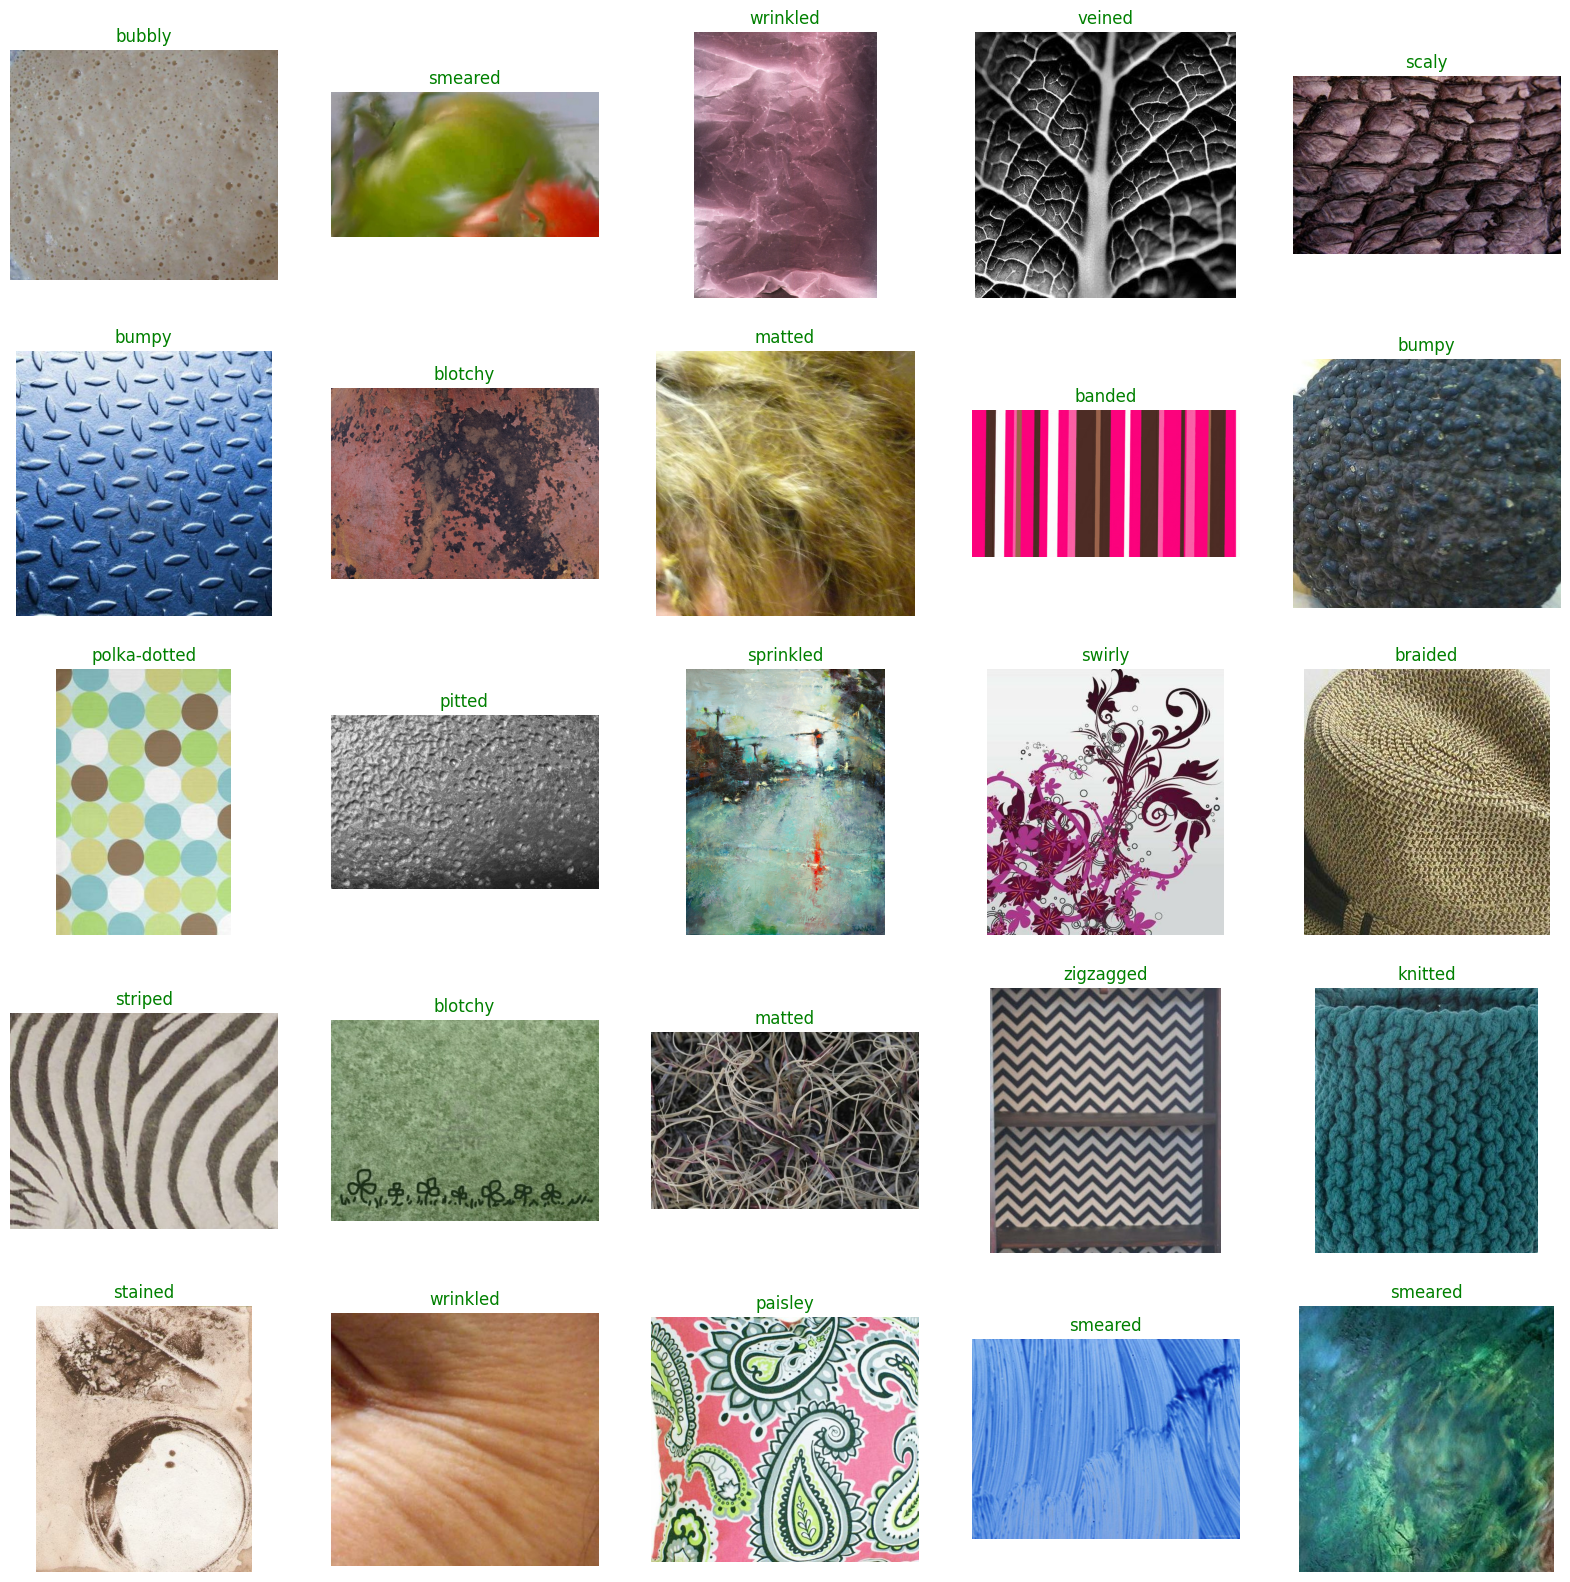

In [10]:
sample = tfds.load("dtd",split='train[95%:]',shuffle_files=True)

plt.figure(figsize=(20,20))
random_state = 36
for i,data in enumerate(tfds.as_numpy(sample.take(25))):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(data['image'])
    plt.title(labels[data['label']],color='green')
    plt.axis("off")
plt.show()

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(32)

# Building a model

In [12]:
model_1 = tf.keras.applications.ResNet50(weights='imagenet',input_shape=(224,224,3) ,include_top=False)

94765736/94765736 [==============================] - 5s 0us/step


In [13]:
model_1.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

# As I mentioned before, I am using a pretrained model we need **the last Convolutional** part and **output Dense layers**. So main body part should remain as trained before. So that we should make the body part non-trainable.

In [14]:
for i in model_1.layers[:-4]:
    i.trainable=False

In [15]:
model_1.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [26]:
class Madel(tf.keras.Model):
    def __init__(self):
        super(Madel,self).__init__()
        self.resnet = model_1
        self.conv1 = keras.layers.Conv2D(filters = 2048,kernel_size=(3,3),activation='relu')
        self.flatten1 = tf.keras.layers.Flatten()
        self.dense_1 = tf.keras.layers.Dense(512,activation='relu')
        self.dense_2 = tf.keras.layers.Dense(47,activation='softmax')
    def call(self,x):
        x = self.resnet(x)
        x = self.conv1(x)
        x = self.flatten1(x)
        x = self.dense_1(x)
        return self.dense_2(x)
model = Madel()

In [27]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=Adam,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [19]:
class myCallback(Callback):
    def on_epoch_end(self,epoch,logs={}):
        if (logs.get("val_accuracy")>0.8):
            print("\n accuracy reached the highest point,cancelling session")
            self.model.stop_training=True
Callback = myCallback()

In [28]:
BATCH_SIZE = 64
Epochs = 300
STEPS_PER_EPOCH = int(info.splits['train'].num_examples * 0.8) // BATCH_SIZE
train_ds = train_ds.repeat()
history = model.fit(train_ds,epochs=Epochs,batch_size=BATCH_SIZE, validation_data = test_ds,steps_per_epoch = STEPS_PER_EPOCH,callbacks=Callback)

Epoch 1/300
23/23 [==============================] - 27s 359ms/step - loss: 13.6386 - accuracy: 0.0190 - val_loss: 3.8338 - val_accuracy: 0.0372
Epoch 2/300
23/23 [==============================] - 5s 229ms/step - loss: 3.8262 - accuracy: 0.0204 - val_loss: 3.8245 - val_accuracy: 0.0319
Epoch 3/300
23/23 [==============================] - 6s 265ms/step - loss: 3.7852 - accuracy: 0.0478 - val_loss: 3.7970 - val_accuracy: 0.0319
Epoch 4/300
23/23 [==============================] - 6s 251ms/step - loss: 3.7514 - accuracy: 0.0312 - val_loss: 3.7751 - val_accuracy: 0.0266
Epoch 5/300
23/23 [==============================] - 5s 220ms/step - loss: 3.7212 - accuracy: 0.0464 - val_loss: 3.7233 - val_accuracy: 0.0372
Epoch 6/300
23/23 [==============================] - 5s 219ms/step - loss: 3.6204 - accuracy: 0.0625 - val_loss: 3.6984 - val_accuracy: 0.0691
Epoch 7/300
23/23 [==============================] - 5s 219ms/step - loss: 3.5909 - accuracy: 0.0765 - val_loss: 3.7070 - val_accuracy: 0.06

In [29]:
model.evaluate(test_ds)

6/6 [==============================] - 1s 132ms/step - loss: 14.3870 - accuracy: 0.1543


[14.387016296386719, 0.15425531566143036]

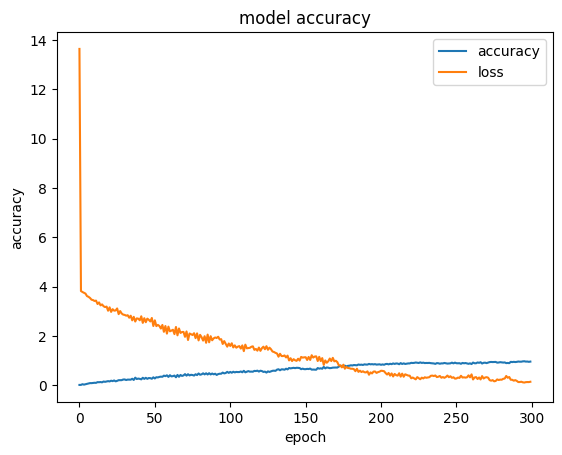

In [31]:
def plotting(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["loss"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["accuracy", "loss"], loc="best")
    plt.show()
plotting(history)

In [ ]:
model.save("Resnet_fine_tune.model",save_format = 'tf')